# 집 가격 예측하기
## 데이터 필드
| **ID**             | 집을 구분하는 번호                                        |
|--------------------|-----------------------------------------------------------|
| **date**           | 집을 구매한 날짜                                           |
| **price**          | 집의 가격(Target variable)                                |
| **bedrooms**       | 침실의 수                                                 |
| **bathrooms**      | 화장실의 수                                               |
| **sqft_living**    | 주거 공간의 평방 피트(면적)                               |
| **sqft_lot**       | 부지의 평방 피트(면적)                                    |
| **floors**         | 집의 층 수                                                |
| **waterfront**     | 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)            |
| **view**           | 집이 얼마나 좋아 보이는지의 정도                           |
| **condition**      | 집의 전반적인 상태                                         |
| **grade**          | King County grading 시스템 기준으로 매긴 집의 등급       |
| **sqft_above**     | 지하실을 제외한 평방 피트(면적)                           |
| **sqft_basement**  | 지하실의 평방 피트(면적)                                  |
| **yr_built**       | 지어진 년도                                               |
| **yr_renovated**   | 집을 재건축한 년도                                       |
| **zipcode**        | 우편번호                                                  |
| **lat**            | 위도                                                      |
| **long**           | 경도                                                      |
| **sqft_living15**  | 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음) |
| **sqft_lot15**     | 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)     |

In [1]:
# import modules
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 추가 로드
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def print_separator():
    print('='*80)

In [3]:
# 데이터의 총갯수 15000개정도

# 결측치가 없는건 이미 암
# lms 노드기준 date컬럼을 int로만, target값 분포만 log로 정규화시킴

# TODO date컬럼을 좀더 세분화
# TODO 원핫인코딩

# TODO 이상치 확인 후 제거
# TODO 마지막 노드기준 LGBMRegressor 모델에서 평가한 기준으로만 submission을 작성했지만 여러 모델로 평가해보기

In [4]:
# data load
data_dir = os.getenv('HOME') + '/aiffel/workspace/06_study/predict_home_price/data'

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv') 

org_train = pd.read_csv(train_data_path)
train = org_train
org_test = pd.read_csv(test_data_path)
test = org_test

### 필요없는 컬럼 제거 및 y변수에 target값 (노드내용)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  in

<AxesSubplot:xlabel='price', ylabel='Density'>

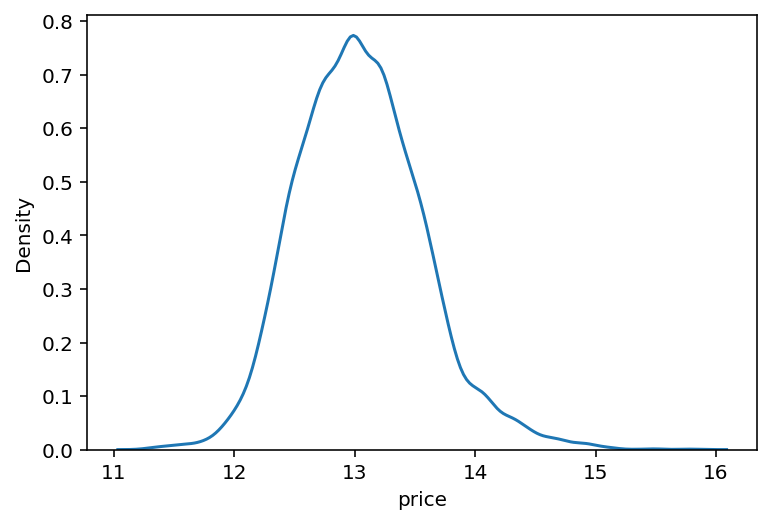

In [5]:
# train dataset -> remove target,id cols
y = train['price']
# 로그변환
y = np.log1p(y)

del train['price']
del train['id']

print_separator()
print(train.columns)
print_separator()
print(train.info())

sns.kdeplot(y) #target값 log화 한 그래프

In [6]:
# test dataset -> remove id col
del test['id']

print_separator()
print(test.columns)
print_separator()
print(test.info())

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   object 
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int6

## date 컬럼 좀더 세분화

### train 데이터셋

In [7]:
# train dataset
# date column -> date
train = org_train
train['date'] = pd.to_datetime(train['date']) # 2014-10-13 < 이형식으로 나옴
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

del train['date'] # datetime 컬럼제거

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  int64  
 3   sqft_lot       15035 non-null  int64  
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  int64  
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  zipcode        15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  int64  
 17  sqft_lot15     15035 non-null  int64  
 18  year  

### test 데이터에도 적용

In [8]:
# test dataset
# date column -> date
test['date'] = pd.to_datetime(test['date']) # 2014-10-13 < 이형식으로 나옴
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

del test['date'] # datetime 컬럼제거

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       6468 non-null   int64  
 1   bathrooms      6468 non-null   float64
 2   sqft_living    6468 non-null   int64  
 3   sqft_lot       6468 non-null   int64  
 4   floors         6468 non-null   float64
 5   waterfront     6468 non-null   int64  
 6   view           6468 non-null   int64  
 7   condition      6468 non-null   int64  
 8   grade          6468 non-null   int64  
 9   sqft_above     6468 non-null   int64  
 10  sqft_basement  6468 non-null   int64  
 11  yr_built       6468 non-null   int64  
 12  yr_renovated   6468 non-null   int64  
 13  zipcode        6468 non-null   int64  
 14  lat            6468 non-null   float64
 15  long           6468 non-null   float64
 16  sqft_living15  6468 non-null   int64  
 17  sqft_lot15     6468 non-null   int64  
 18  year    

## 원 핫 인코딩

### train 데이터 셋

In [9]:
all_cols = list(train.columns)
all_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year',
 'month',
 'day']

In [10]:
def len_unique_raw(train, test, cols, extra_cols=[]):
    same_col = []

    for col in cols:
        if col in extra_cols:
            continue

        # 값이 같은 컬럼
        train_data = set(train[col])
        test_data = set(test[col])
        if train_data == test_data:
            # bedrooms 12
            # test 9
            print(f'colum이름 {col}')
            same_col.append(col)
    return same_col
        
one_hot_encoding_cols = len_unique_raw(train,test,all_cols,extra_cols=['zipcode','year','month','day']) #우편번호 연 월 일 은 배제
one_hot_encoding_cols

        
# # ['floors','waterfront','view','condition','yr_built']
# one_hot_encoding_cols = ['floors','waterfront','view','condition','yr_built']

# train.shape

colum이름 floors
colum이름 waterfront
colum이름 view
colum이름 condition
colum이름 yr_built


['floors', 'waterfront', 'view', 'condition', 'yr_built']

In [11]:
def one_hot_encoding(df,cols):
    for col in cols:
        dummy = pd.get_dummies(data=df[col],prefix=col)
        df = pd.concat([df, dummy], axis=1)
        
    return df

# 원핫 인코딩 적용
train = one_hot_encoding(train, one_hot_encoding_cols)

# 적용한 기존 컬럼들 삭제
train = train.drop(columns=one_hot_encoding_cols)

train.shape

(15035, 150)

### test 데이터 셋도 적용

In [12]:
test = one_hot_encoding(test, one_hot_encoding_cols)
test = test.drop(columns=one_hot_encoding_cols)

test.shape

(6468, 150)

## 훈련 및 결과 저장

### 평가지표 rmse로

In [13]:
# rmse 함수
def rmse(y_test, y_pred):
    # y의 값을 log로 변환 (np.log1p함수로)했으니 다시 (np.expm1로 원래 숫자로 변환)
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 하이퍼 파라미터 grid search로 최적값 찾기

In [60]:
def run_grid_search(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearch model
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    # train, test 데이터셋 분리 8:2
    X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.2,random_state=random_state)
    
    # model을 grid search fit 수행
    grid_model.fit(X_train,y_train)
    
    # grid result
    best_params = grid_model.best_params_
    
    # (최적의 하이퍼파라미터 값을지닌 모델, 최적의하이퍼파라미터 각각 반환)
    return (grid_model.best_estimator_, grid_model.best_params_)

### 여러 모델 grid search 최적의 하이퍼 파라미터로 rmse로 평가

In [69]:
# 각 모델별로 학습하고 결과 저장하기
random_state=2024
def get_scores(models, train, y):
    
    # 결과 저장용 dict
    df = {}
    # 찾고싶은 하이퍼파라미터 순서대로(lightgbm, gboost, xgboost, rdforest) 정의
    # 한번에 실행이 안되서 하나씩 주석하면서 진행함
    param_grids = [
#         # lightgbm
#         {
#             'num_leaves': [31, 63],
#             'learning_rate': [0.01, 0.05]
#         },
#         # gboost
#         {
#             # 학습에 사용할 트리의 개수를 의미 트리의 개수가 많을수록 과적합이 될수 있음
#             'n_estimators': [100],
#             #  트리의 최대 깊이
#             'max_depth': [5, 7]
#         },
#         #xgboost,
#         {
#             'n_estimators': [100],
#             'max_depth': [3, 7]
#         },
        # rdforest
        {
            'n_estimators': [100],
            'max_depth': [10, 30]
        }
        
    ]
    
    for model,param_grid in zip(models, param_grids):
        # grid search 수행 
        # return으로 가장 best 하이퍼파라미터를 가진 모델, best 하이퍼파라미터 값을 주게만듬
        grid_model, best_params = run_grid_search(model, train, y, param_grid, verbose=2, n_jobs=5)
        
        
        # 모델 이름 획득
        model_name = grid_model.__class__.__name__
        print_separator()
        print(f'{model_name}의 best 하이퍼파라미터: {best_params}')

        # train, test 데이터셋 분리 8:2
        X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.2,random_state=random_state)
        

        # 예측
        y_pred = grid_model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name+'_rmse'] = rmse(y_test,y_pred)
        df[model_name+'_pred'] = np.expm1(y_pred)

        # data frame에 저장
        # score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return df

In [43]:
# 한번에 돌릴라고 했는데 응답이 안옴..
# 여러 모델을 실험해볼거 (lightgbm, gboost, xgboost, rdforest)
# get_scores의 params_grids 하나씩 주석하면서 진행함

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# models = [lightgbm, gboost, xgboost, rdforest]

# result = get_scores(models, train, y)
# result

### lightgbm

In [55]:
# lightgbm
models = [lightgbm]
result_lightgbm = get_scores(models, train, y)
result_lightgbm

Fitting 5 folds for each of 4 candidates, totalling 20 fits
LGBMRegressor의 best 하이퍼파라미터: {'learning_rate': 0.05, 'num_leaves': 63}


{'LGBMRegressor_rmse': 171184.92974679414,
 'LGBMRegressor_pred': array([799665.89316198, 604201.33870115, 316491.6574923 , ...,
        728131.31764693, 336744.81068476, 747594.60608537])}

### gboost

In [66]:
# gboost
models = [gboost]
result_gboost = get_scores(models, train, y)
result_gboost

Fitting 5 folds for each of 2 candidates, totalling 10 fits
GradientBoostingRegressor의 best 하이퍼파라미터: {'max_depth': 7, 'n_estimators': 100}


{'GradientBoostingRegressor_rmse': 154899.34202184723,
 'GradientBoostingRegressor_pred': array([952606.75250716, 616532.40334051, 312753.72940259, ...,
        719675.54448322, 337945.90445471, 707075.4886877 ])}

### xgboost

In [68]:
# xgboost
models = [xgboost]
result_xgboost = get_scores(models, train, y)
result_xgboost

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

XGBRegressor의 best 하이퍼파라미터: {'max_depth': 7, 'n_estimators': 100}


{'XGBRegressor_rmse': 158379.76719403503,
 'XGBRegressor_pred': array([889175.  , 643969.5 , 301057.78, ..., 685859.06, 332284.53,
        662935.94], dtype=float32)}

### rdforest

In [70]:
# rdforest
models = [rdforest]
result_rdforest = get_scores(models, train, y)
result_rdforest

Fitting 5 folds for each of 2 candidates, totalling 10 fits
RandomForestRegressor의 best 하이퍼파라미터: {'max_depth': 30, 'n_estimators': 100}


{'RandomForestRegressor_rmse': 164666.00352969716,
 'RandomForestRegressor_pred': array([804893.12395363, 613876.76369948, 346606.41656607, ...,
        780456.59869689, 332442.19887189, 641110.94094272])}

In [82]:
# RMSE 값

print_separator()
print("RMSE lightgbm",result_lightgbm['LGBMRegressor_rmse'])
print_separator()
print("RMSE gboost",result_gboost['GradientBoostingRegressor_rmse'])
print_separator()
print("RMSE xboost",result_xgboost['XGBRegressor_rmse'])
print_separator()
print("RMSE randomforest",result_rdforest['RandomForestRegressor_rmse'])

RMSE lightgbm 171184.92974679414
RMSE gboost 154899.34202184723
RMSE xboost 158379.76719403503
RMSE randomforest 164666.00352969716


In [83]:
# 각 예측값

print_separator()
print("Pred lightgbm", result_lightgbm['LGBMRegressor_pred'])
print_separator()
print("Pred gboost", result_gboost['GradientBoostingRegressor_pred'])
print_separator()
print("Pred XGBOOST", result_xgboost['XGBRegressor_pred'])
print_separator()
print("Pred rdforest", result_rdforest['RandomForestRegressor_pred'])

Pred lightgbm [799665.89316198 604201.33870115 316491.6574923  ... 728131.31764693
 336744.81068476 747594.60608537]
Pred gboost [952606.75250716 616532.40334051 312753.72940259 ... 719675.54448322
 337945.90445471 707075.4886877 ]
Pred XGBOOST [889175.   643969.5  301057.78 ... 685859.06 332284.53 662935.94]
Pred rdforest [804893.12395363 613876.76369948 346606.41656607 ... 780456.59869689
 332442.19887189 641110.94094272]


# 회고

내가 너무많은 원핫인코딩을해서 모델의 복잡성이 증가해 시간이 엄청오래 걸리는거같다. 먼저 시각화를 해보든 다른 방법으로 데이터를 보고 원핫인코딩을 해야겠고, 맨위쪽 TODO에는 이상치 처리도 하고싶어서 적어놨는데 시간이 너무 부족했다